# Summary
This notebook walks through some basic steps of using braggedgemodeling for
modeling of neutron Bragg edge spectrum.

First we import some essential tools

In [1]:
import os, numpy as np
import warnings
%matplotlib notebook
from matplotlib import pyplot as plt
from bem.matter import Atom, Lattice, Structure

# Atomic structure
The first step is to create a model of the material. Here we use bcc Fe as the example.
In the following cell, we create the atomic structure of bcc Fe by adding atoms
to a lattice with a space group.

In [2]:
atoms = [Atom('Fe', (0,0,0)), Atom('Fe', (0.5, 0.5, 0.5))]
a=2.856
alpha = 90.
lattice = Lattice(a=a, b=a, c=a, alpha=alpha, beta=alpha, gamma=alpha)
astruct = Structure(atoms, lattice, sgid=229)

It is also possible to load the atomic structure of the material from a structure file in CIF format. This is an example:

```
from bem.matter import loadCif
astruct = loadCif(path)
```

# No texture
It is always good to start with a simplified case. Here we consider a bcc Fe sample without texture, 
and the following code computes and plots various contributions to the neutron cross section for this
material.

The neutron Bragg edge spectrum is wavelength ($\lambda$) dependent, so we will calculate the cross sections
as functions of $\lambda$

## Define wavelength axis

In [3]:
wavelengths = np.arange(0.05, 5.5, 0.005)

## Experimental condition

In [11]:
T = 300 # Kelvin

## Calculate cross sections

Create calculator. Larger max_diffraction_index will lead to more accurate result at low wavelength

In [5]:
from bem import xscalc
xscalculator = xscalc.XSCalculator(astruct, T, max_diffraction_index=4)

Compute various contributions

Note: in neutron Bragg Edge data analysis, it may not be necessary to calculate all these
contributions, but it is useful to see them when exploring.

<IPython.core.display.Javascript object>


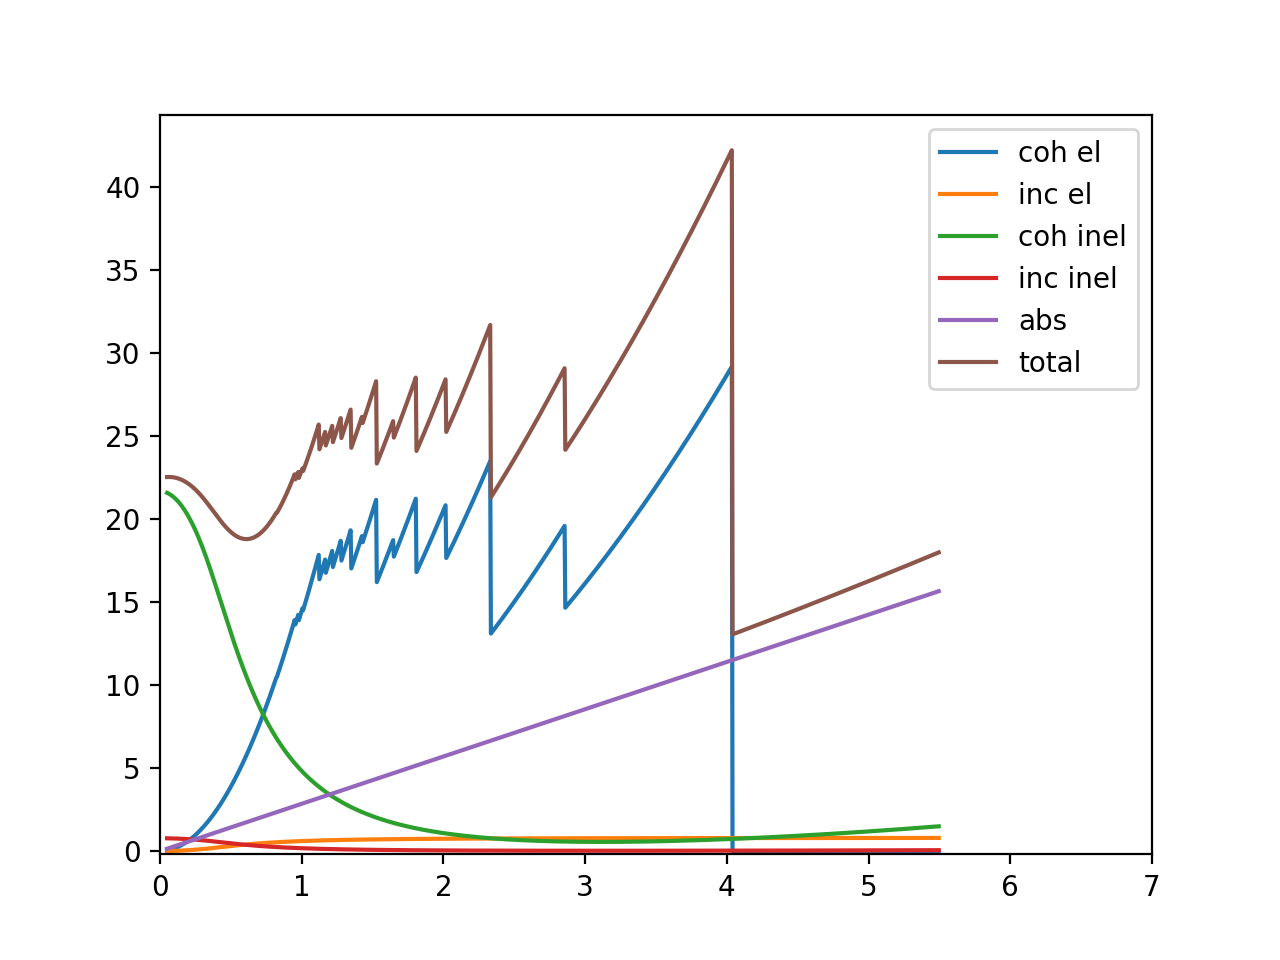

In [6]:
coh_el_xs = xscalculator.xs_coh_el(wavelengths)
inc_el_xs = xscalculator.xs_inc_el(wavelengths)
abs_xs = xscalculator.xs_abs(wavelengths)
coh_inel_xs = xscalculator.xs_coh_inel(wavelengths)
inc_inel_xs = xscalculator.xs_inc_inel(wavelengths)
# and the total cross section
total = xscalculator.xs(wavelengths)
# plot
plt.figure()
plt.plot(wavelengths, coh_el_xs, label='coh el')
plt.plot(wavelengths, inc_el_xs, label='inc el')
plt.plot(wavelengths, coh_inel_xs, label='coh inel')
plt.plot(wavelengths, inc_inel_xs, label='inc inel')
plt.plot(wavelengths, abs_xs, label='abs')
plt.plot(wavelengths, total, label='total')
plt.ylim(-0.2, None)
plt.xlim(0,7)
plt.legend()

# Texture
Here we introduce texture into the sample using the March Dollas model and see how it influence the spectrum 

In March Dollase model,

* the $r$ parameter of a $hkl$ indicates the degree of anisotropy;
* $r_{hkl}=1$ means the sample is isotropic with respect to the distribution of the particular $hkl$;
* $\beta$ is the most probable angle of the preferred orientation

In the following, we create a March Dollas model and adjust the $r$ and $\beta$ for [011]

In [7]:
from bem import xtaloriprobmodel as xopm
texture_model = xopm.MarchDollase()
texture_model.r[(0,1,1)] = 2
texture_model.beta[(0,1,1)] = np.deg2rad(60.)

calculate and plot

<IPython.core.display.Javascript object>


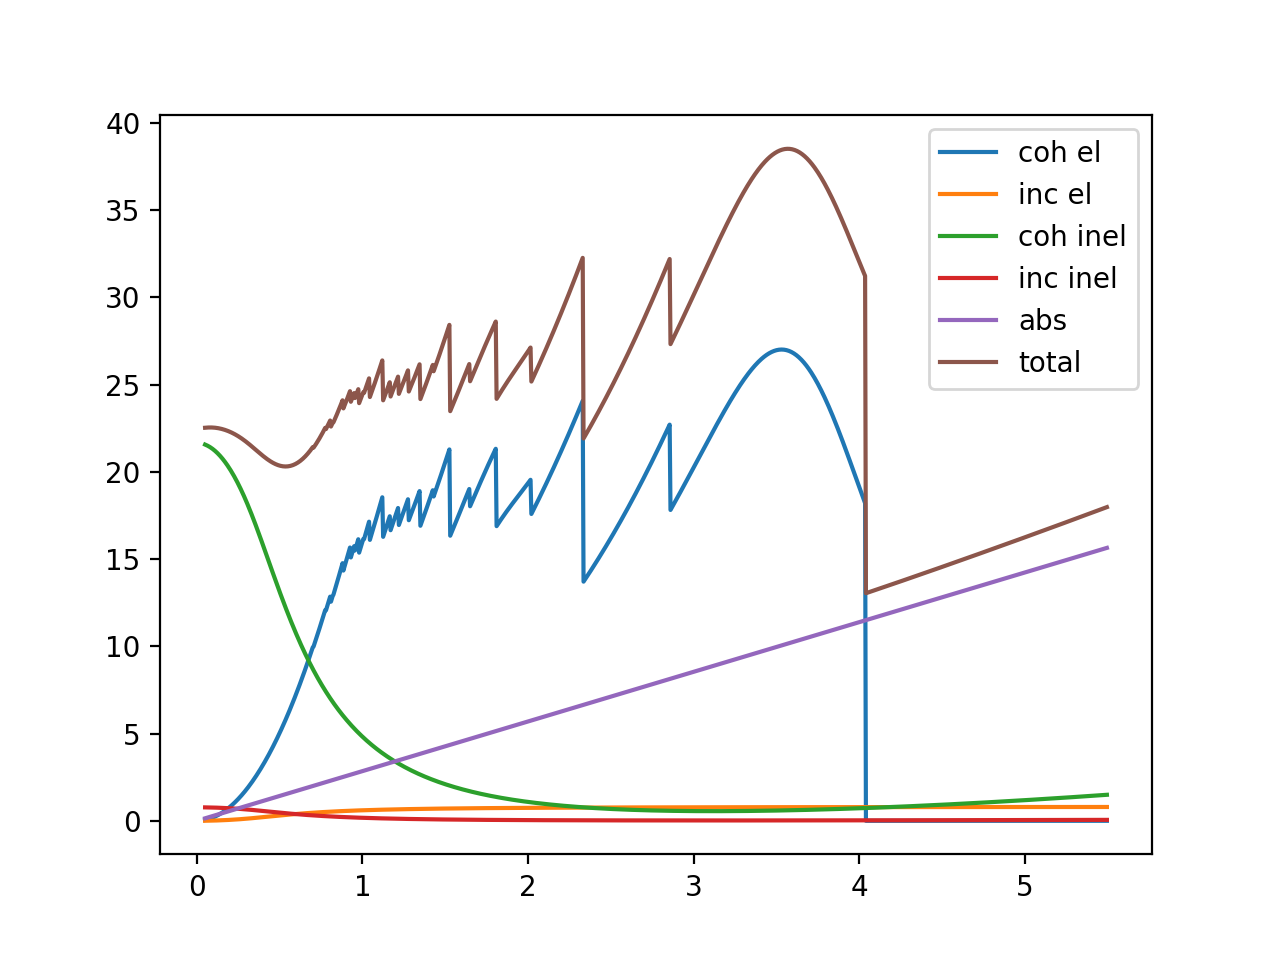

In [8]:
xscalculator = xscalc.XSCalculator(astruct, T, texture_model)

plt.figure()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # plotAll is a convenient method that calculates all contributions and plot them
    xscalculator.plotAll(wavelengths)

The following code consider the isotropic case and three texture cases for bcc Fe.
This plot reproduces Figure 1 of https://doi.org/10.1088/1742-6596/251/1/012070

<IPython.core.display.Javascript object>


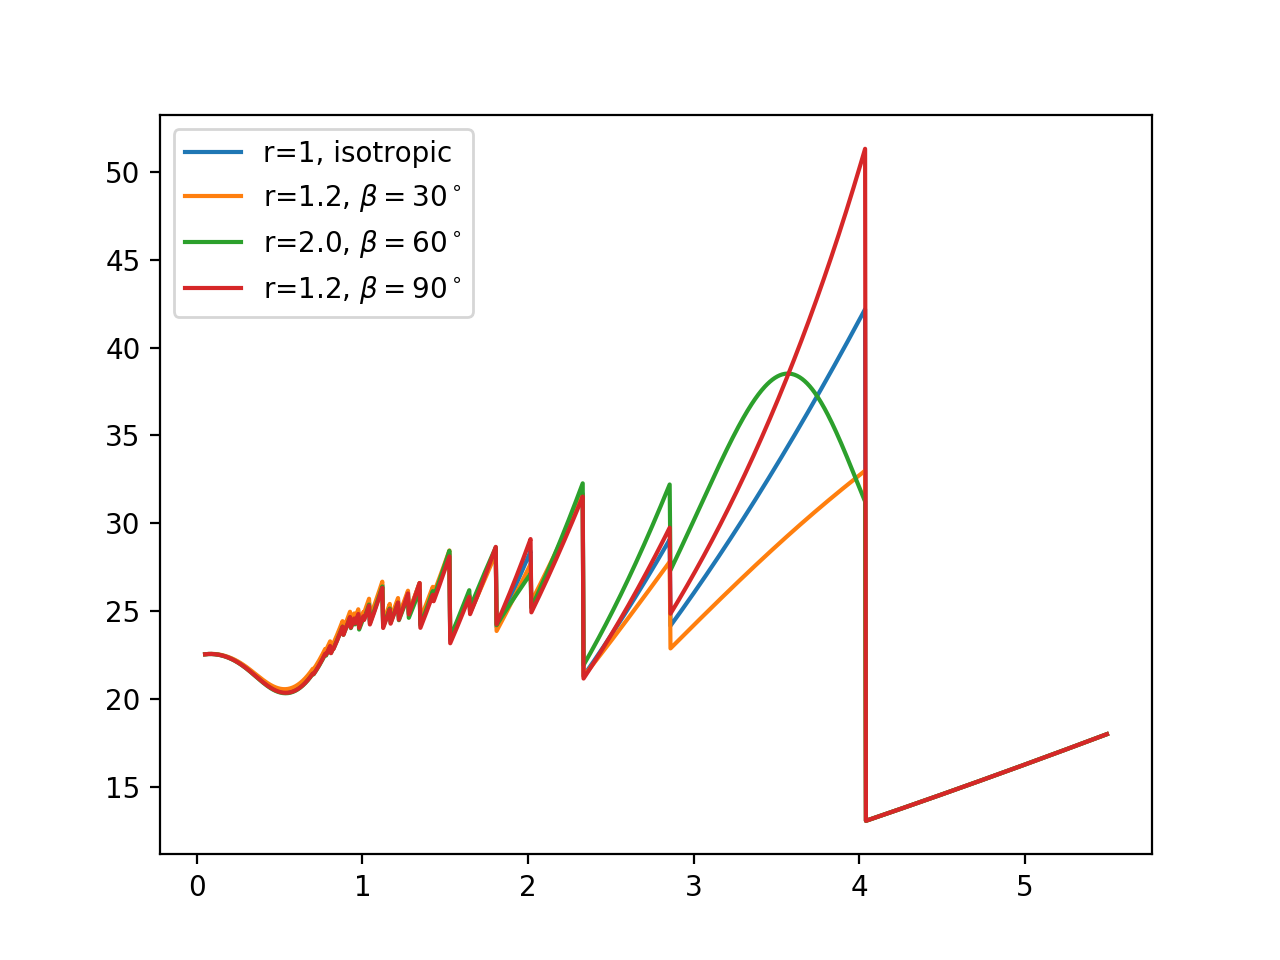

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    texture_model = xopm.MarchDollase()
    calc = xscalc.XSCalculator(astruct, T, texture_model, max_diffraction_index=5)
    # isotropic
    xs_0 = calc.xs(wavelengths)
    # r = 2, beta = 60.
    texture_model.r[(0,1,1)] = 2
    texture_model.beta[(0,1,1)] = 60./180.*np.pi
    xs_60 = calc.xs(wavelengths)
    # r = 1.2, beta = 30
    texture_model.r[(0,1,1)] = 1.2
    texture_model.beta[(0,1,1)] = 30./180.*np.pi
    xs_30 = calc.xs(wavelengths)
    # r = 1.2, beta = 90
    texture_model.r[(0,1,1)] = 1.2
    texture_model.beta[(0,1,1)] = 90./180.*np.pi
    xs_90 = calc.xs(wavelengths)

plt.figure()
plt.plot(wavelengths, xs_0, label='r=1, isotropic')
plt.plot(wavelengths, xs_30, label='r=1.2, $\\beta=30^\\circ$')
plt.plot(wavelengths, xs_60, label='r=2.0, $\\beta=60^\\circ$')
plt.plot(wavelengths, xs_90, label='r=1.2, $\\beta=90^\\circ$')
plt.legend(loc='upper left')

# Peak profile
The peak profile takes care of broadening due to neutron source.

<IPython.core.display.Javascript object>


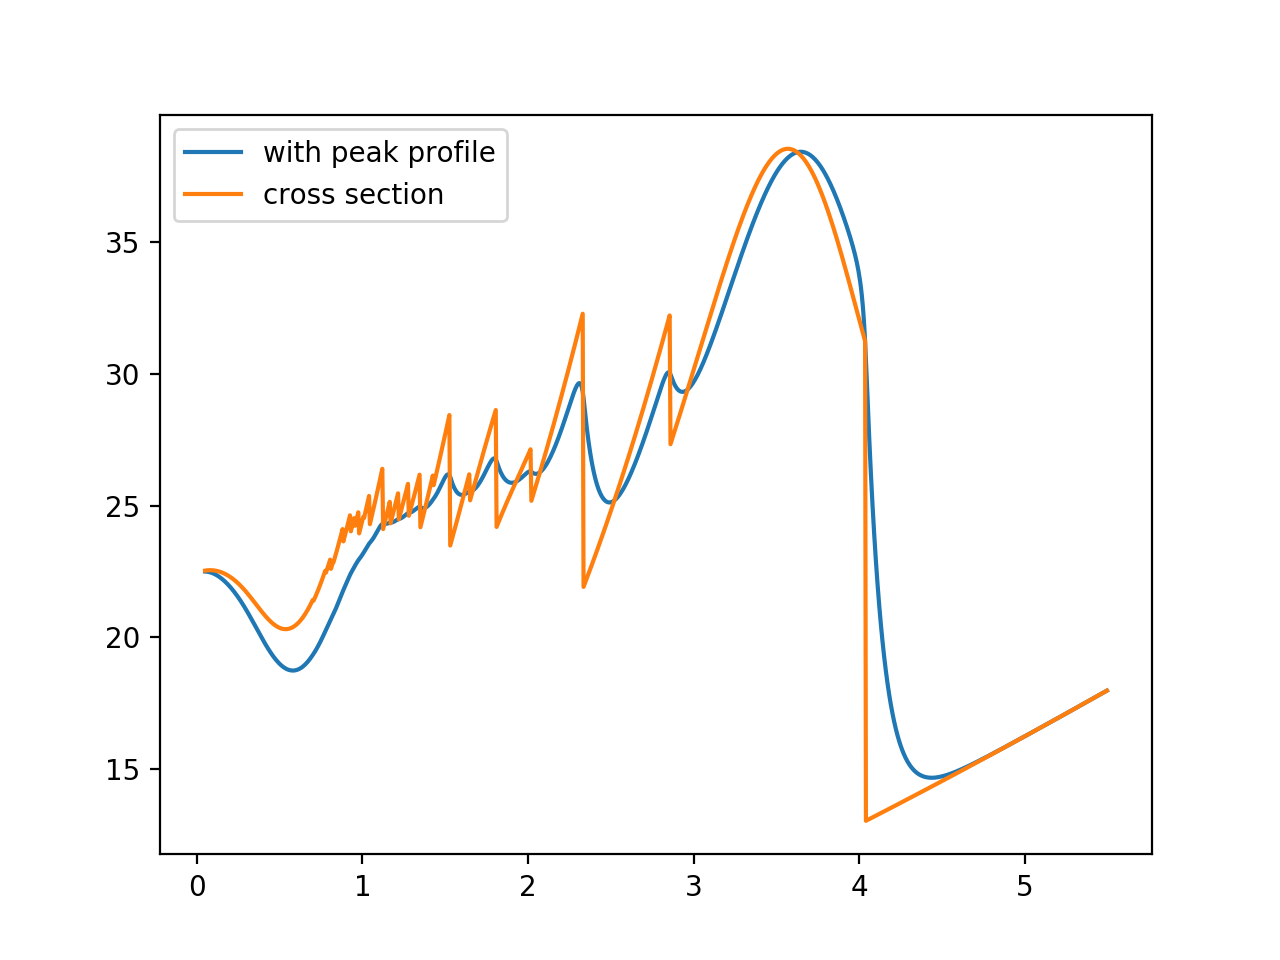

In [10]:
from bem import peak_profile as pp, calc
jorgensen = pp.Jorgensen(alpha=[50, 0.], beta=[10, 0], sigma=[0, .003, 0])
spectrum_calculator = calc.BraggEdgeSpectrumCalculator(xscalculator, jorgensen)
# calculate total cross section convolved with peak profile
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    spectrum = spectrum_calculator('total', wavelengths)
    xs = xscalculator.xs(wavelengths)
# plot it
plt.figure()
plt.plot(wavelengths, spectrum, label='with peak profile')
plt.plot(wavelengths, xs, label='cross section')
plt.legend()